In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import timeit
import matplotlib.pyplot as plt
from numba import jit
from scipy.stats import t
from scipy.stats import norm
from scipy.stats import multivariate_normal
from mpl_toolkits import mplot3d
from scipy.special import gamma
from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

In [2]:
@jit
def ratio(x,mu,sigma,df,c):
    return t.pdf(x,df)/(c*norm.pdf(x,mu,sigma)) 

@jit
def rejection_sampling1(L,c,mu,sigma,df):
    y=np.zeros(L)
    i=0
    j=0
    while i<L:
        j+=1
        x=np.random.normal(mu,sigma,1)
        if np.random.uniform(0,1,1)<=ratio(x,mu,sigma,df,c):
            y[i]=x
            i+=1  
    return y,j        

@jit
def rejection_sampling2(L,c,mu,sigma,df):
    y=np.zeros(L)
    i=j=0
    while i<L:
        j+=1
        x=np.random.normal(mu,sigma,1)
        if np.random.uniform(0,1,1)<=ratio(x,mu,sigma,df,c):
            y[i]=x
            c_star=np.maximum(c,c*ratio(x,mu,sigma,df,c))
            c=c_star
            i+=1  
    return y,c,j 

@jit
def sup_norm(y,z,z_min,z_max):
    grid = GridSearchCV(KernelDensity(),{'bandwidth': np.linspace(0.1, 1.0, 30)},cv=10)
    grid.fit(y[:,None])
    kde = grid.best_estimator_ 
    z_grid = np.linspace(z_min,z_max,10000)
    pdf_kde = np.exp(kde.score_samples(z_grid[:,None])) 
    error = np.max(np.absolute(np.subtract(z,pdf_kde)))
    return error

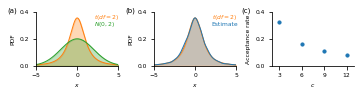

In [140]:
#Description of target and candidate distribution
mu=0
sigma=2
df=2
fontsiz=6
x=np.linspace(-5,5,10000)

f,axes=plt.subplots(1,3,figsize=(5,1.3))
plt.rcParams['font.size'] = fontsiz
axes[0].plot(x,t.pdf(x,df),c='C1',label=r't (df=%d)' %df,linewidth=1)
axes[0].fill_between(x, 0, t.pdf(x,df),alpha=0.3,color='C1')
axes[0].plot(x,norm.pdf(x,mu,sigma),c='C2',label='N($\mu=%1.1f$,$\sigma$=%d)' %(mu,sigma),linewidth=1)
axes[0].fill_between(x, 0, norm.pdf(x,mu,sigma),alpha=0.3,color='C2')
axes[0].text(2,0.35,r'$t(df=2)$',color='C1')
axes[0].text(2,0.3,r'$N(0,2)$',color='C2')

c=3
L=10000
y,_=rejection_sampling1(L,c,mu,sigma,df)
axes[1].plot(x,t.pdf(x,df),c='C1',linewidth=1)
axes[1].fill_between(x, 0, t.pdf(x,df),alpha=0.3,color='C1')
axes[1].text(2,0.35,r'$t(df=2)$',color='C1')
axes[1].text(2,0.3,'Estimate',color='C0')
sns.kdeplot(y,shade=True,ax=axes[1],linewidth=1)

c=[3,6,9,12]
L=10000
accept_rate=np.zeros(len(c))
for i in range(len(c)):
    y,iteration=rejection_sampling1(L,c[i],mu,sigma,df)
    accept_rate[i]=L/iteration  
axes[2].scatter(c,accept_rate,s=10)
axes[2].set_xticks(c)
axes[2].set_yticks([0,0.2,0.4])
axes[2].set_xlim([2,13])
axes[2].set_ylim([0,0.4])
axes[2].set_ylabel('Acceptance rate')

for i in range(2):
    axes[i].set_ylabel('PDF')
    axes[i].set_xlim([-5,5])
    axes[i].set_ylim([0,0.4])
    axes[i].set_yticks(np.linspace(0,0.4,3))
    axes[i].set_xticks(np.linspace(-5,5,3))
xlabels=[r'$x$',r'$x$',r'$c$']
for i in range(3):
    axes[i].set_xlabel(xlabels[i],fontsize=fontsiz)
    axes[i].spines['right'].set_color('none')
    axes[i].spines['top'].set_color('none')
plt.tight_layout()
axes[0].text(-8.5,0.4,'(a)',fontsize=fontsiz+1)
axes[1].text(-8.5,0.4,'(b)',fontsize=fontsiz+1)
axes[2].text(-2,0.4,'(c)',fontsize=fontsiz+1)
f.savefig('1.2.1D_sampling.jpg', format='jpg', dpi=500,bbox_inches="tight")
plt.show()

# Multivariate version

In [128]:
def plot_contour(X,Y,z,sample):
    cmap='YlGn'
    sns.kdeplot(sample[0,:],sample[1,:],cmap=cmap,shade=True,ax=axes[1])
    axes[0].contourf(X,Y,z,cmap=cmap)
    for i in range(2):
        axes[i].set_xlim([-3,3])
        axes[i].set_ylim([-3,3])
        axes[i].set_xticks([-3,0,3])
        axes[i].set_yticks([-3,0,3])
        axes[i].spines['right'].set_color('none')
        axes[i].spines['top'].set_color('none')
        axes[i].set_xlabel(r'$x_1$')
    axes[0].set_ylabel(r'$x_2$')
    axes[1].set_yticklabels([])
    axes[1].set_title('Density contour estimate')
    axes[0].set_title('True density contour')
    
@jit
def t_pdf(x,mu,df,sigma):
    p=np.shape(sigma)[1]
    ex=p/2
    A=gamma((df+p)/2)
    B=gamma(df/2)*(df**ex)*(np.pi**ex)*np.sqrt(np.linalg.det(sigma))
    C=(1+((1/df)*np.dot(np.dot((x-mu),np.linalg.inv(sigma)),np.transpose(x-mu))))**(-(df+p)/2)
    return A*C/B

@jit
def twod_ratio(x,df,mu_t,mu_normal,cov_t,cov_normal,c):
    return t_pdf(x,mu_t,df,cov_t)/(c*multivariate_normal.pdf(x,mu_normal,cov_normal)) 

@jit
def twod_rejection_sampling_2(df,mu_t,mu_normal,cov_t,cov_normal,c,L):
    y=np.zeros([len(mu_t),L+1])
    i=j=0
    rho=cov_normal[0,1]/np.sqrt(cov_normal[0,0]*cov_normal[1,1])
    while i<L:
        j+=1
        cond_mu = mu_normal[i%2]+np.sqrt(cov_normal[i%2,i%2])*rho*(y[(i+1)%2,i]-mu_normal[(i+1)%2])/np.sqrt(cov_normal[(i+1)%2,(i+1)%2])
        x=np.random.normal(cond_mu,np.sqrt(cov_normal[i%2,i%2]*(1-rho**2)),1) 
        if i%2==0:
            prop=np.array([y[0,i],x])
        else:
            prop=np.array([x,y[1,i]])     
        if np.random.uniform(0,1,1)<=twod_ratio(prop,df,mu_t,mu_normal,cov_t,cov_normal,c):
                y[:,i+1]=prop
                i+=1           
    return y,j 

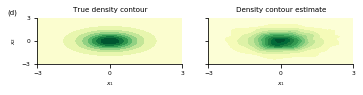

In [154]:
mu_t = np.array([0, 0])
mu_normal = np.array([0, 0])
cov_normal = np.array([[2, 0], [0, 2]])
cov_t = np.array([[1, 0], [0, 1]])
df=2
c=3
L=10000
start = timeit.default_timer()
sample,iteration=twod_rejection_sampling_2(df,mu_t,mu_normal,cov_t,cov_normal,c,L)
stop = timeit.default_timer()
  
fontsiz=6
f, axes = plt.subplots(1,2,figsize=(5,1.3))
plt.rcParams['font.size'] = fontsiz
x = np.linspace(-3, 3, 500)
y = np.linspace(-3, 3, 500)
X, Y = np.meshgrid(x, y)
z=np.zeros([500,500])
for i in range(500):
    for j in range(500):
        z[i,j]= t_pdf([X[i,j],Y[i,j]],mu_t,df,cov_t)  
plot_contour(X,Y,z,sample)   
plt.tight_layout(w_pad=3)
axes[0].text(-4.25,3.5,'(d)',fontsize=fontsiz+1)
f.savefig('1.2.2D_sampling.jpg', format='jpg', dpi=500,bbox_inches="tight")